In [59]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import itertools
from numpy import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score 
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

In [60]:
df1=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig01.dat')
df2=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig02.dat')
df3=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig03.dat')
df4=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig04.dat')
df5=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig05.dat')
df6=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig06.dat')
df7=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig07.dat')
df8=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig08.dat')
df9=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig09.dat')
df10=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig10.dat')
df11=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig11.dat')
df12=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig12.dat')
df13=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig13.dat')
df14=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig14.dat')
df15=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig15.dat')
df16=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig16.dat')
df17=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig17.dat')
df18=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig18.dat')
df19=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig19.dat')
df20=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig20.dat')
df21=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig21.dat')
df22=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig22.dat')
df23=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig23.dat')
df24=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig24.dat')
df25=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig25.dat')


In [61]:
dff =[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23, df24, df25]

In [62]:
#Function to read the files and separate each AGN and its errors.

def agns(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=[] #AGNs
    err_agn=[] #AGNs errors
    star=[] #Calibration Stars
    err_star=[] #Calibration Stars errors
    agn_p=[] #Periodic AGNs
    err_agn_p=[] #Periodic AGNs errors

    for i in range(1, 544, 2):

        if i <  400: 
 
            agns = data[:,i]
            err_agns = data[:,i+1]
            agn.append(agns)
            err_agn.append(err_agns)
            
        elif i > 400 and i < 526:
   
            stars = data[:,i]
            err_stars = data[:,i+1]
            star.append(stars)
            err_star.append(err_stars)
            
        elif i > 526: 

            agn_ps = data[:,i]
            err_agn_ps = data[:,i+1]
            agn_p.append(agn_ps)
            err_agn_p.append(err_agn_ps)
            
    return agn, err_agn, star, err_star, agn_p, err_agn_p, t
                                       
    

In [63]:
#We calibrate the observed fluxes of the AGNs using the calibration stars.

#For this, we choose for each AGN the star that has the magnitude most similar to that of the AGN.


#We use the mean of each star and AGN for comparison. 


#We define a function that calculates the star with mean magnitude most similar to the AGN and then subtracts those magnitudes and this is what we will use to determine

#whether an AGN is variable or not.

def calibration(agn, star, err_agn, err_star):

    rest = []
    
    for i in range(63):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude

        err_cal = err_agn + err_star[ind_min]#Error calibrated magnitude 
        
    return cal, err_cal

In [64]:
def extract_features(mag, err_p, err_m):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
        'err_p_mag_mean': np.mean(err_p),
        'err_p_mag_var': np.var(err_p),
        'err_p_mag_skew': skew(err_p),
        'err_p_mag_kurt': kurtosis(err_p),
        'err_m_mag_mean': np.mean(err_m),
        'err_m_mag_var': np.var(err_m),
        'err_m_mag_skew': skew(err_m),
        'err_m_mag_kurt': kurtosis(err_m),
    }
    
    return features

In [65]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [66]:
#Observation times of each file.

t1 = agns(df1)[6]
t2 = agns(df2)[6]
t3 = agns(df3)[6]
t4 = agns(df4)[6]
t5 = agns(df5)[6]
t6 = agns(df6)[6]
t7 = agns(df7)[6]
t8 = agns(df8)[6]
t9 = agns(df9)[6]
t10 = agns(df10)[6]
t11 = agns(df11)[6]
t12 = agns(df12)[6]
t13 = agns(df13)[6]
t14 = agns(df14)[6]
t15 = agns(df15)[6]
t16 = agns(df16)[6]
t17 = agns(df17)[6]
t18 = agns(df18)[6]
t19 = agns(df19)[6]
t20 = agns(df20)[6]
t21 = agns(df21)[6]
t22 = agns(df22)[6]
t23 = agns(df23)[6]
t24 = agns(df24)[6]
t25 = agns(df25)[6]

In [67]:
#AGNs and each errors

agn1 = agns(df1)[0]
err_agn1 = agns(df1)[1]
agn2 = agns(df2)[0]
err_agn2 = agns(df2)[1]
agn3 = agns(df3)[0]
err_agn3 = agns(df3)[1]
agn4 = agns(df4)[0]
err_agn4 = agns(df4)[1]
agn5 = agns(df5)[0]
err_agn5 = agns(df5)[1]
agn6 = agns(df6)[0]
err_agn6 = agns(df6)[1]
agn7 = agns(df7)[0]
err_agn7 = agns(df7)[1]
agn8 = agns(df8)[0]
err_agn8 = agns(df8)[1]
agn9 = agns(df9)[0]
err_agn9 = agns(df9)[1]
agn10 = agns(df10)[0]
err_agn10 = agns(df10)[1]
agn11 = agns(df11)[0]
err_agn11 = agns(df11)[1]
agn12 = agns(df12)[0]
err_agn12 = agns(df12)[1]
agn13 = agns(df13)[0]
err_agn13 = agns(df13)[1]
agn14 = agns(df14)[0]
err_agn14 = agns(df14)[1]
agn15 = agns(df15)[0]
err_agn15 = agns(df15)[1]
agn16 = agns(df16)[0]
err_agn16 = agns(df16)[1]
agn17 = agns(df17)[0]
err_agn17 = agns(df17)[1]
agn18 = agns(df18)[0]
err_agn18 = agns(df18)[1]
agn19 = agns(df19)[0]
err_agn19 = agns(df19)[1]
agn20 = agns(df20)[0]
err_agn20 = agns(df20)[1]
agn21 = agns(df21)[0]
err_agn21 = agns(df21)[1]
agn22 = agns(df22)[0]
err_agn22 = agns(df22)[1]
agn23 = agns(df23)[0]
err_agn23 = agns(df23)[1]
agn24 = agns(df24)[0]
err_agn24 = agns(df24)[1]
agn25 = agns(df25)[0]
err_agn25 = agns(df25)[1]

In [68]:
#Calibration Stars and each errors

star1 = agns(df1)[2]
err_star1 = agns(df1)[3]
star2 = agns(df2)[2]
err_star2 = agns(df2)[3]
star3 = agns(df3)[2]
err_star3 = agns(df3)[3]
star4 = agns(df4)[2]
err_star4 = agns(df4)[3]
star5 = agns(df5)[2]
err_star5 = agns(df5)[3]
star6 = agns(df6)[2]
err_star6 = agns(df6)[3]
star7 = agns(df7)[2]
err_star7 = agns(df7)[3]
star8 = agns(df8)[2]
err_star8 = agns(df8)[3]
star9 = agns(df9)[2]
err_star9 = agns(df9)[3]
star10 = agns(df10)[2]
err_star10 = agns(df10)[3]
star11 = agns(df11)[2]
err_star11 = agns(df11)[3]
star12 = agns(df12)[2]
err_star12 = agns(df12)[3]
star13 = agns(df13)[2]
err_star13 = agns(df13)[3]
star14 = agns(df14)[2]
err_star14 = agns(df14)[3]
star15 = agns(df15)[2]
err_star15 = agns(df15)[3]
star16 = agns(df16)[2]
err_star16 = agns(df16)[3]
star17 = agns(df17)[2]
err_star17 = agns(df17)[3]
star18 = agns(df18)[2]
err_star18 = agns(df18)[3]
star19 = agns(df19)[2]
err_star19 = agns(df19)[3]
star20 = agns(df20)[2]
err_star20 = agns(df20)[3]
star21 = agns(df21)[2]
err_star21 = agns(df21)[3]
star22 = agns(df22)[2]
err_star22 = agns(df22)[3]
star23 = agns(df23)[2]
err_star23 = agns(df23)[3]
star24 = agns(df24)[2]
err_star24 = agns(df24)[3]
star25 = agns(df25)[2]
err_star25 = agns(df25)[3]

In [69]:
#Varables AGNs an each errors

agn_p1 = agns(df1)[4]
err_agn_p1 = agns(df1)[5]
agn_p2 = agns(df2)[4]
err_agn_p2 = agns(df2)[5]
agn_p3 = agns(df3)[4]
err_agn_p3 = agns(df3)[5]
agn_p4 = agns(df4)[4]
err_agn_p4 = agns(df4)[5]
agn_p5 = agns(df5)[4]
err_agn_p5 = agns(df5)[5]
agn_p6 = agns(df6)[4]
err_agn_p6 = agns(df6)[5]
agn_p7 = agns(df7)[4]
err_agn_p7 = agns(df7)[5]
agn_p8 = agns(df8)[4]
err_agn_p8 = agns(df8)[5]
agn_p9 = agns(df9)[4]
err_agn_p9 = agns(df9)[5]
agn_p10 = agns(df10)[4]
err_agn_p10 = agns(df10)[5]
agn_p11 = agns(df11)[4]
err_agn_p11 = agns(df11)[5]
agn_p12 = agns(df12)[4]
err_agn_p12 = agns(df12)[5]
agn_p13 = agns(df13)[4]
err_agn_p13 = agns(df13)[5]
agn_p14 = agns(df14)[4]
err_agn_p14 = agns(df14)[5]
agn_p15 = agns(df15)[4]
err_agn_p15 = agns(df15)[5]
agn_p16 = agns(df16)[4]
err_agn_p16 = agns(df16)[5]
agn_p17 = agns(df17)[4]
err_agn_p17 = agns(df17)[5]
agn_p18 = agns(df18)[4]
err_agn_p18 = agns(df18)[5]
agn_p19 = agns(df19)[4]
err_agn_p19 = agns(df19)[5]
agn_p20 = agns(df20)[4]
err_agn_p20 = agns(df20)[5]
agn_p21 = agns(df21)[4]
err_agn_p21 = agns(df21)[5]
agn_p22 = agns(df22)[4]
err_agn_p22 = agns(df22)[5]
agn_p23 = agns(df23)[4]
err_agn_p23 = agns(df23)[5]
agn_p24 = agns(df24)[4]
err_agn_p24 = agns(df24)[5]
agn_p25 = agns(df25)[4]
err_agn_p25 = agns(df25)[5]

In [70]:
#Create an save the dataframe to a CSV file

def dataframe(df, N, p, star, err_star, c, x): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset

        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        err_p = mag + err_mag
        err_m = mag - err_mag
        
        # Extract features from the time series data
        features = extract_features(mag, err_p, err_m)
        
        # Store the features and the target variable
        data_features.append(features)

        if p == 1:
            variability.append(1)
        else:
            variability.append(0)

    return data_features

In [71]:
#First whit the non-variable AGNs

data_features = []
data_features_p = []
variability = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 200, 0, star, err_star, 0, 1)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [72]:
#Then with the variable AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 9, 1, star, err_star, 4, 5)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [73]:
features_df

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
0,0.010450,0.000020,-0.233428,-0.543255,0.016450,0.000020,-0.233428,-0.543255,0.004450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,-0.020100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,-0.015125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,0.001900,0.000017,-0.199723,-0.703788,-0.010100,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,0.006325,0.000013,-0.097803,-0.743768,-0.005675,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,0.030025,0.006243,-0.145639,-1.101369,-0.002375,0.006280,-0.118861,-1.075591,1
5221,-0.012100,0.004425,-0.281331,-1.361673,0.004100,0.004470,-0.292878,-1.350930,-0.028300,0.004399,-0.264609,-1.367214,1
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,-0.004375,0.001547,-0.180160,0.470815,1
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,-0.030650,0.001103,-0.060833,-1.125633,1


In [74]:
features_df.isna().sum()

mag_mean          0
mag_var           0
mag_skew          0
mag_kurt          0
err_p_mag_mean    0
err_p_mag_var     0
err_p_mag_skew    0
err_p_mag_kurt    0
err_m_mag_mean    0
err_m_mag_var     0
err_m_mag_skew    0
err_m_mag_kurt    0
Variability       0
dtype: int64

In [75]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [76]:
features_df.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.981870,-0.039593,0.048969,0.025883,0.978575,-0.036943,0.001821,0.027471,-0.100698
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.023797,0.999149,-0.067844,-0.155983,-0.059328,0.998679,-0.040626,-0.160259,0.756343
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.016450,-0.053768,0.833663,0.225264,0.036321,-0.069904,0.852010,-0.131266,-0.094039
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.064135,-0.152355,0.265941,0.894173,-0.011460,-0.150304,-0.173598,0.896775,-0.218651
err_p_mag_mean,0.981870,-0.023797,0.016450,0.064135,1.000000,-0.018835,0.090943,0.059622,0.921806,-0.014338,-0.050480,0.060505,-0.109615
err_p_mag_var,-0.039593,0.999149,-0.053768,-0.152355,-0.018835,1.000000,-0.055640,-0.149188,-0.060513,0.997345,-0.044902,-0.154524,0.753628
err_p_mag_skew,0.048969,-0.067844,0.833663,0.265941,0.090943,-0.055640,1.000000,0.428347,0.001364,-0.062443,0.459982,0.118510,-0.155117
err_p_mag_kurt,0.025883,-0.155983,0.225264,0.894173,0.059622,-0.149188,0.428347,1.000000,-0.011827,-0.148516,-0.036637,0.665208,-0.212685
err_m_mag_mean,0.978575,-0.059328,0.036321,-0.011460,0.921806,-0.060513,0.001364,-0.011827,1.000000,-0.059977,0.058556,-0.009540,-0.086872
err_m_mag_var,-0.036943,0.998679,-0.069904,-0.150304,-0.014338,0.997345,-0.062443,-0.148516,-0.059977,1.000000,-0.056754,-0.152697,0.751556


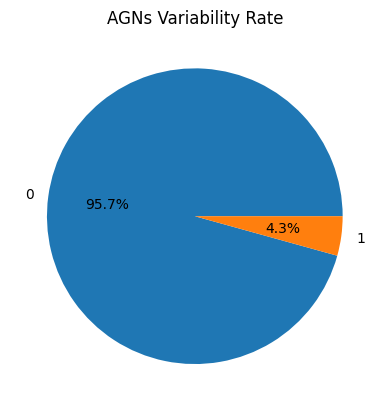

In [77]:
pie_x, pie_y = np.unique(features_df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

#### As we can see, this dataset is very unbalanced.

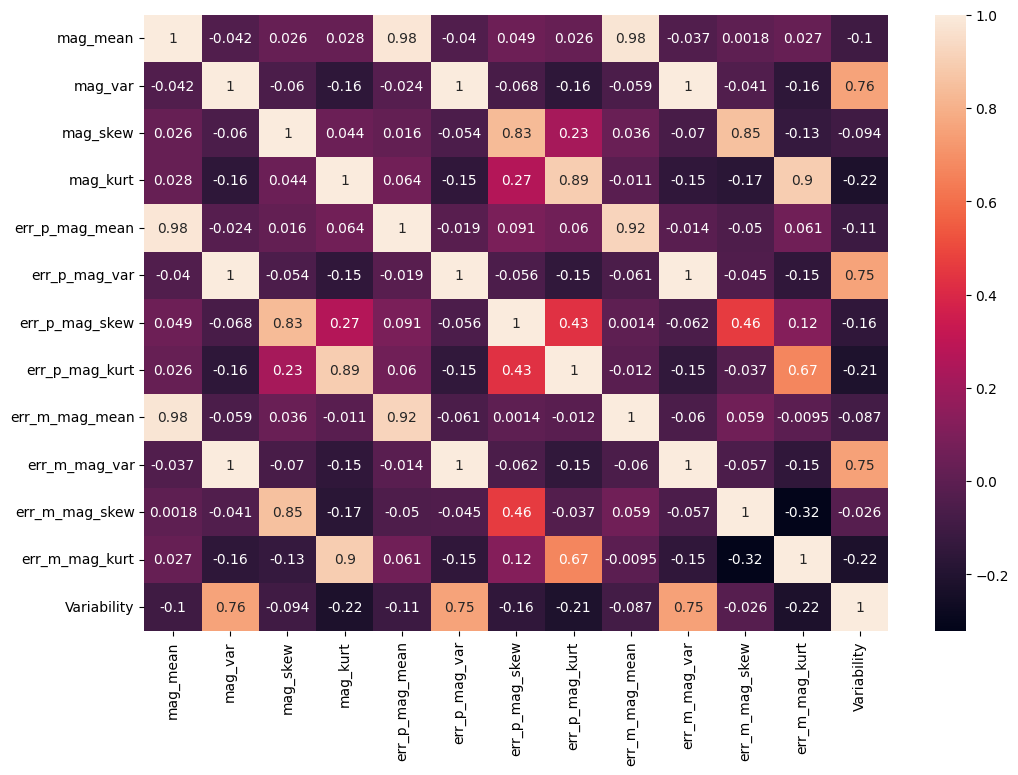

In [78]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df.corr(), annot=True)
plt.show()

In [79]:
features_df.Variability.value_counts()

Variability
0    5000
1     225
Name: count, dtype: int64

In [80]:
df_0 = features_df[features_df['Variability'] == 0 ].sample(n=500)

In [81]:
df_0

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
2916,-0.009750,0.000052,-0.550535,1.270934,-0.000525,0.000057,-0.187317,0.068170,-0.018975,0.000051,-0.878073,2.760860,0
502,0.009950,0.000029,0.106737,-0.315784,0.017950,0.000029,0.106737,-0.315784,0.001950,0.000029,0.106737,-0.315784,0
3100,0.002000,0.000093,0.431557,0.583181,0.017550,0.000093,0.459978,0.480714,-0.013550,0.000094,0.391204,0.654185,0
2983,0.054650,0.000058,-0.560012,0.187216,0.065850,0.000060,-0.268366,-0.066602,0.043450,0.000060,-0.817452,0.668436,0
4778,0.030025,0.000435,-0.105354,-0.402135,0.058775,0.000540,0.512987,-0.150069,0.001275,0.000462,-0.834935,-0.092578,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,-0.000925,0.000048,-0.172457,-0.190959,0.007075,0.000045,0.577645,0.178011,-0.008925,0.000065,-0.636902,-0.190764,0
4807,0.014425,0.000085,-0.381738,-0.096738,0.026175,0.000085,0.029774,-0.517216,0.002675,0.000096,-0.733510,0.667311,0
938,0.009650,0.000027,-0.345260,-0.316997,0.019550,0.000027,-0.382904,-0.278973,-0.000250,0.000027,-0.309062,-0.326139,0
1455,-0.014500,0.000019,0.440147,-0.696889,-0.008075,0.000018,0.396114,-0.563896,-0.020925,0.000021,0.369036,-0.795242,0


In [82]:
df_1 =  features_df[features_df['Variability'] == 1 ].sample(n=216)

In [83]:
df_1

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
5008,-0.010075,0.000197,0.350484,-0.636713,-0.003075,0.000197,0.350484,-0.636713,-0.017075,0.000197,0.350484,-0.636713,1
5011,-0.006975,0.002187,-0.954562,-0.471383,-0.000975,0.002187,-0.954562,-0.471383,-0.012975,0.002187,-0.954562,-0.471383,1
5184,0.007975,0.009183,0.183955,-1.352877,0.029200,0.009523,0.171762,-1.368631,-0.013250,0.008903,0.196005,-1.319656,1
5051,0.000350,0.001795,0.166953,-1.189452,0.007350,0.001795,0.166953,-1.189452,-0.006650,0.001795,0.166953,-1.189452,1
5092,-0.008350,0.002143,-0.925455,-0.596044,0.000450,0.002175,-0.937140,-0.592910,-0.017150,0.002112,-0.911708,-0.600792,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,-0.013125,0.003337,-0.001419,-1.203329,-0.007125,0.003337,-0.001419,-1.203329,-0.019125,0.003337,-0.001419,-1.203329,1
5118,-0.012800,0.003372,0.052106,-1.167064,-0.005150,0.003550,0.067903,-1.165809,-0.020450,0.003199,0.035582,-1.167642,1
5102,-0.006175,0.001023,-0.698673,-0.839934,0.001825,0.000955,-0.676322,-0.838058,-0.014175,0.001103,-0.708152,-0.835533,1
5176,-0.004275,0.003909,-0.717886,-0.172728,0.003525,0.003930,-0.725661,-0.158468,-0.012075,0.003889,-0.709342,-0.187620,1


In [84]:
df = pd.concat([df_0, df_1])

In [85]:
df.index =  range(df.shape[0])

In [86]:
df

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
0,-0.009750,0.000052,-0.550535,1.270934,-0.000525,0.000057,-0.187317,0.068170,-0.018975,0.000051,-0.878073,2.760860,0
1,0.009950,0.000029,0.106737,-0.315784,0.017950,0.000029,0.106737,-0.315784,0.001950,0.000029,0.106737,-0.315784,0
2,0.002000,0.000093,0.431557,0.583181,0.017550,0.000093,0.459978,0.480714,-0.013550,0.000094,0.391204,0.654185,0
3,0.054650,0.000058,-0.560012,0.187216,0.065850,0.000060,-0.268366,-0.066602,0.043450,0.000060,-0.817452,0.668436,0
4,0.030025,0.000435,-0.105354,-0.402135,0.058775,0.000540,0.512987,-0.150069,0.001275,0.000462,-0.834935,-0.092578,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,-0.013125,0.003337,-0.001419,-1.203329,-0.007125,0.003337,-0.001419,-1.203329,-0.019125,0.003337,-0.001419,-1.203329,1
712,-0.012800,0.003372,0.052106,-1.167064,-0.005150,0.003550,0.067903,-1.165809,-0.020450,0.003199,0.035582,-1.167642,1
713,-0.006175,0.001023,-0.698673,-0.839934,0.001825,0.000955,-0.676322,-0.838058,-0.014175,0.001103,-0.708152,-0.835533,1
714,-0.004275,0.003909,-0.717886,-0.172728,0.003525,0.003930,-0.725661,-0.158468,-0.012075,0.003889,-0.709342,-0.187620,1


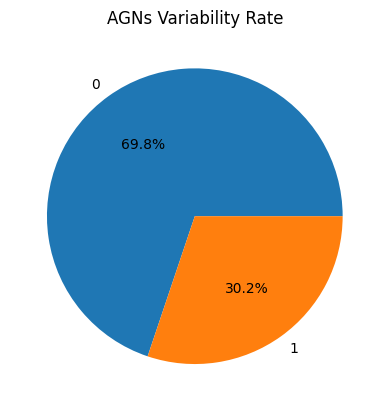

In [87]:
pie_x, pie_y = np.unique(df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

### Machine Learning models

In [88]:
#Apply a Machine Learning model, a Logistic Regression.

data1 = features_df.copy()

X = data1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data1['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
clf = LogisticRegression(random_state=0)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
r2_score(y_pred, y_test)

-1.6738798071268954

We'll try to improve the model.

In [89]:
#Apply a Random Forest classifier with the original dataset.

data = features_df.copy()

# Split the data into features and target
X = data.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_score(y_pred,y_test)

0.9968112244897959

In [90]:
#Another Machine Learning model, a Random Forest classifier with an UnderSampling.

# Split the data into features and target
X = df.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = df['Variability']

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier1 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier1.fit(X1_train, y1_train)

# Make predictions on the test set
y1_pred = rf_classifier1.predict(X1_test)

# Evaluate the model
accuracy_score(y1_pred,y1_test)

0.9861111111111112

In [91]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data_1 = features_df.copy()

# Split the data into features and target
X = data_1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data_1['Variability']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X11_train, X11_test, y11_train, y11_test = train_test_split(X_res, y_res, test_size=0.3, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier11 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier11.fit(X11_train, y11_train)

# Make predictions on the test set
y11_pred = rf_classifier11.predict(X11_test)

# Evaluate the model
accuracy_score(y11_pred,y11_test)

0.9966666666666667

#### We use the metrics to evaluate the model

Metrics of first Random Forest Model

In [92]:
confusion = metrics.confusion_matrix(y_test, y_pred)
confusion.ravel()

array([1500,    0,    5,   63])

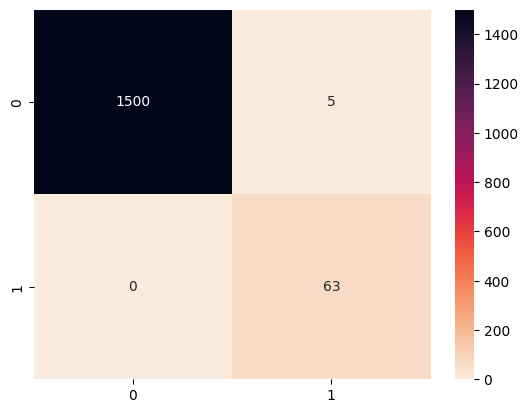

In [93]:
mc=confusion_matrix(y_pred,y_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [94]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='precision').mean()

1.0

In [95]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='recall').mean()

0.8986453797774553

In [96]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='f1').mean()

0.9354633057807499

Metrics of model with UnderSampling

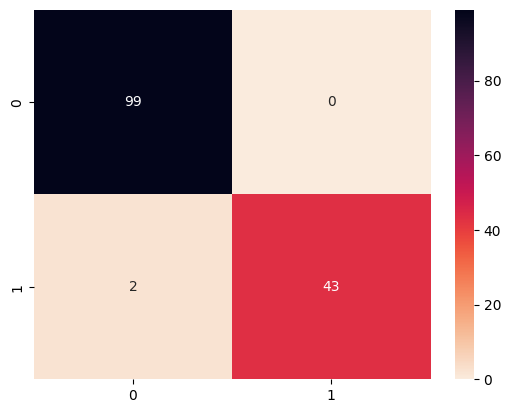

In [97]:
mc=confusion_matrix(y1_pred,y1_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [98]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='precision').mean()

0.9942528735632185

In [99]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='recall').mean()

0.9712643678160919

In [100]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='f1').mean()

0.9795036110263452

Metrics of model with OverSampling

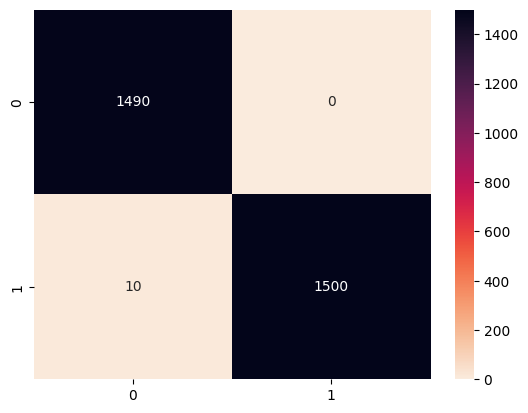

In [101]:
mc=confusion_matrix(y11_pred,y11_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [102]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='precision').mean()

0.9937619388408742

In [103]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='recall').mean()

1.0

In [104]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='f1').mean()

0.9974371087176465

#### The second Random Forest model its better, so we will use this one.

In [105]:
#Precision score
precision_score(y1_pred, y1_test)

1.0

In [106]:
#Specificity score
specificity_score(y1_pred,y1_test)

1.0

In [107]:
#ROC AUC score
roc_auc_score(y1_pred,y1_test)

0.9777777777777779

In [108]:
#Recall score
recall_score(y1_test, y1_pred) 

1.0

In [109]:
#F1 score
f1_score(y1_test, y1_pred) 

0.9772727272727273

In [110]:
print(classification_report(y1_test,y1_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       101
           1       0.96      1.00      0.98        43

    accuracy                           0.99       144
   macro avg       0.98      0.99      0.98       144
weighted avg       0.99      0.99      0.99       144



grid search

### Now we'll use real observations of some AGNs to classify them.  

In [111]:
#Function to read the observations and separate each AGN and calibration Stars.

def agns1(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=data[:,1] #AGN magnitude
    cal_star=[] #Calibration Stars
    
    for i in range(2, 9, 1):

        if i != 6 and i != 8:

            stars = data[:,i]
            cal_star.append(stars)

    return agn, cal_star, t

In [112]:
def calibration1(agn, star):

    rest = []
    
    for i in range(5):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude
            
    return cal

In [113]:
def subsample_time_series(mag, t, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: AGN magnitudes
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data mag.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return mag[subsample_indices], t[subsample_indices]

In [114]:
def extract_features_obs(mag):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }
    
    return features

In [131]:
#Create a dataframe for the observations an save it to a CSV file

def dataframe_obs(df): 
    
    D1 = df['D1'] #Diference between AGN and calibration star magnitudes
    err_D1 = df['eD1'] #error of the diference between AGN and calibration star magnitudes
    D2 = df['D2'] #Diference between AGN and control star magnitudes
    err_D2 = df['eD2'] #error of the diference between AGN and calibration star magnitudes

    #Calculates the Diference between D1 and D2
    mag = D1
  
    # Subsample the time series data to simulate incomplete observations
    #mag_subsampled = subsample_time_series(mag, t, subsample_size)        
    
    # Extract features from the time series data
    features_obs = extract_features_obs(mag)
        
    return features_obs

In [132]:
#List all the AGNs, each one is a directory

dir = '/home/anakin/Documents/Tesis/Codigo/AGNs/'
names_agns = os.listdir(dir)
names_agns 

['agn_1424',
 'agn_0521',
 'agn_1116',
 'agn_1229',
 'agn_1958',
 'agn_1510',
 'agn_1256',
 'agn_0208',
 'agn_2005',
 'agn_1917',
 'agn_2310',
 'agn_0847',
 'agn_1127',
 'agn_0414',
 'agn_1443',
 'agn_2149',
 'agn_2126',
 'agn_2155']

In [133]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)

            # Store the features and the target variable
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_obs = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted = rf_classifier1.predict(features_df_obs)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs.to_csv('observations_AGNs.csv', index=False)


1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [1] with 9 observations
------------------------------------------------- agn_1424 is variable whit a probability of: 50.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is variable whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [1] with 12 observations
1116V-130415.csv :Classified [1] with 15 observations
1116V-140415.csv :Classified [1] with 12 observations
------------------------------------------------- agn_1116 is variable whit a probability of: 75.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is variable whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-

In [134]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs
0,0.134444,0.001408,0.036509,-1.374585,1424V-140415.csv
1,0.505583,0.000739,-0.350275,-0.518960,1116R-140415.csv
2,0.231000,0.001032,0.000302,-1.331876,1116V-130415.csv
3,0.114417,0.001354,-0.440058,-1.304029,1116V-140415.csv
4,1.096625,0.000972,2.146290,2.836030,1510V-040419.csv
5,1.205333,0.001417,0.287314,-1.301265,0208R-130815.csv
6,1.376333,0.002242,0.707265,-1.228609,0208V-150915.csv
7,0.806667,0.000922,-0.400996,-0.672578,0208V-130815.csv
8,-2.234739,0.000183,0.385175,-0.785997,2005R-020919.csv
9,-2.263333,0.000294,-0.320410,-0.844935,2005R-030919.csv


### Now we perform a model to classify periodics AGNs.

In [135]:
#Create an save the dataframe to a CSV file

def dataframe1(df, N, p, star, err_star, c, x, a): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset
        p = 0
        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        err_p = mag + err_mag
        err_m = mag - err_mag
        
        # Extract features from the time series data
        features = extract_features(mag, err_p, err_m)
        
        # Store the features and the target variable
        data_features1.append(features)

        if i == 3 and a == 3:

            p = 1
        
        if p == 1:
            
            Periodicity.append(1)
        else:
            
            Periodicity.append(0)

    return data_features1

In [136]:
#First whit the non-periodic AGNs

data_features1 = []
Periodicity = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features1 = dataframe1(dt, 200, 0, star, err_star, 0, 1, 0)

    # Convert lists to a DataFrame
    features_df1 = pd.DataFrame(data_features1)
    features_df1['Periodicity'] = Periodicity       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [137]:
#Then with the periodics AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features1 = dataframe1(dt, 9, 0, star, err_star, 4, 5, 3)

    # Convert lists to a DataFrame
    features_df1 = pd.DataFrame(data_features1)
    features_df1['Periodicity'] = Periodicity       


In [138]:
features_df1

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
0,0.010450,0.000020,-0.233428,-0.543255,0.016450,0.000020,-0.233428,-0.543255,0.004450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,-0.020100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,-0.015125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,0.001900,0.000017,-0.199723,-0.703788,-0.010100,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,0.006325,0.000013,-0.097803,-0.743768,-0.005675,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,0.030025,0.006243,-0.145639,-1.101369,-0.002375,0.006280,-0.118861,-1.075591,0
5221,-0.012100,0.004425,-0.281331,-1.361673,0.004100,0.004470,-0.292878,-1.350930,-0.028300,0.004399,-0.264609,-1.367214,0
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,-0.004375,0.001547,-0.180160,0.470815,0
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,-0.030650,0.001103,-0.060833,-1.125633,0


In [139]:
features_df.isna().sum()

mag_mean          0
mag_var           0
mag_skew          0
mag_kurt          0
err_p_mag_mean    0
err_p_mag_var     0
err_p_mag_skew    0
err_p_mag_kurt    0
err_m_mag_mean    0
err_m_mag_var     0
err_m_mag_skew    0
err_m_mag_kurt    0
Variability       0
dtype: int64

In [140]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [141]:
features_df1.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.981870,-0.039593,0.048969,0.025883,0.978575,-0.036943,0.001821,0.027471,-0.036430
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.023797,0.999149,-0.067844,-0.155983,-0.059328,0.998679,-0.040626,-0.160259,0.075249
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.016450,-0.053768,0.833663,0.225264,0.036321,-0.069904,0.852010,-0.131266,-0.094154
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.064135,-0.152355,0.265941,0.894173,-0.011460,-0.150304,-0.173598,0.896775,-0.077549
err_p_mag_mean,0.981870,-0.023797,0.016450,0.064135,1.000000,-0.018835,0.090943,0.059622,0.921806,-0.014338,-0.050480,0.060505,-0.040969
err_p_mag_var,-0.039593,0.999149,-0.053768,-0.152355,-0.018835,1.000000,-0.055640,-0.149188,-0.060513,0.997345,-0.044902,-0.154524,0.073686
err_p_mag_skew,0.048969,-0.067844,0.833663,0.265941,0.090943,-0.055640,1.000000,0.428347,0.001364,-0.062443,0.459982,0.118510,-0.110310
err_p_mag_kurt,0.025883,-0.155983,0.225264,0.894173,0.059622,-0.149188,0.428347,1.000000,-0.011827,-0.148516,-0.036637,0.665208,-0.075708
err_m_mag_mean,0.978575,-0.059328,0.036321,-0.011460,0.921806,-0.060513,0.001364,-0.011827,1.000000,-0.059977,0.058556,-0.009540,-0.030003
err_m_mag_var,-0.036943,0.998679,-0.069904,-0.150304,-0.014338,0.997345,-0.062443,-0.148516,-0.059977,1.000000,-0.056754,-0.152697,0.075419


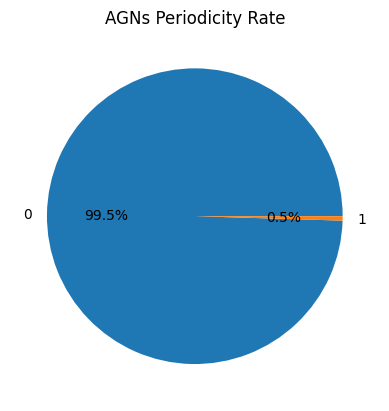

In [142]:
pie_x, pie_y = np.unique(features_df1['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

#### This dataset is very unbalanced.

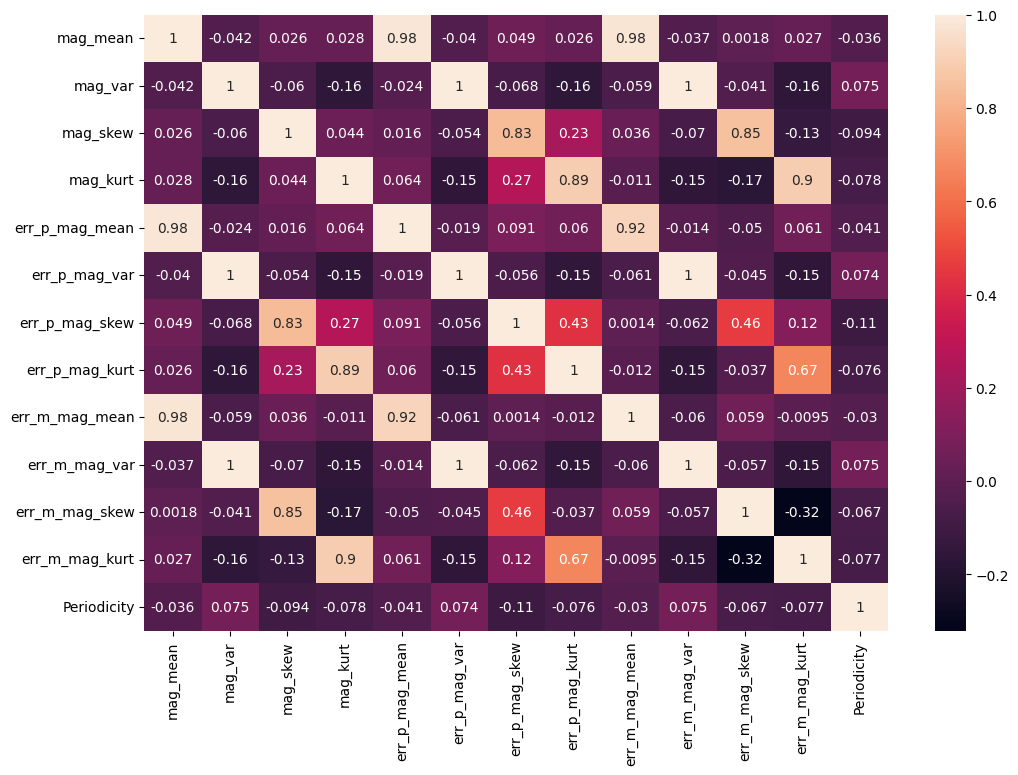

In [143]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df1.corr(), annot=True)
plt.show()

In [144]:
features_df1['Periodicity'].value_counts()

Periodicity
0    5200
1      25
Name: count, dtype: int64

In [145]:
df_2 = features_df1[features_df1['Periodicity'] == 0 ].sample(n=100)

In [146]:
df_2

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
4189,0.081150,0.000587,-0.455512,0.125702,0.114475,0.000599,0.115473,-0.019719,0.047825,0.000698,-0.787007,0.223625,0
1053,0.006050,0.000018,0.586071,1.333221,0.012300,0.000018,0.667923,1.243123,-0.000200,0.000020,0.433600,1.283993,0
633,-0.005650,0.000021,-0.180633,-0.702002,0.000350,0.000021,-0.180633,-0.702002,-0.011650,0.000021,-0.180633,-0.702002,0
2971,-0.005925,0.000074,-0.527009,-0.266599,0.005275,0.000079,-0.254477,-0.509406,-0.017125,0.000073,-0.781778,0.188577,0
1706,0.000800,0.000029,0.608733,0.133750,0.008800,0.000029,0.608733,0.133750,-0.007200,0.000029,0.608733,0.133750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,-0.009950,0.000028,-0.130355,-0.247840,-0.002675,0.000029,0.052450,-0.287384,-0.017225,0.000029,-0.295208,-0.244966,0
2837,0.013750,0.000023,-0.053586,0.152085,0.020550,0.000023,0.271156,0.149474,0.006950,0.000025,-0.335634,0.199712,0
2769,0.013250,0.000093,-0.888949,2.894186,0.025925,0.000090,-0.222444,1.409236,0.000575,0.000112,-1.285944,3.734378,0
671,0.004850,0.000027,-0.311726,-0.937681,0.012850,0.000027,-0.311726,-0.937681,-0.003150,0.000027,-0.311726,-0.937681,0


In [147]:
df_3 = features_df1[features_df1['Periodicity'] == 1 ].sample(n=24)

In [148]:
df_3

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
5102,-0.006175,0.001023,-0.698673,-0.839934,0.001825,0.000955,-0.676322,-0.838058,-0.014175,0.001103,-0.708152,-0.835533,1
5021,-0.005300,0.000946,-0.543974,-1.099840,0.000700,0.000946,-0.543974,-1.099840,-0.011300,0.000946,-0.543974,-1.099840,1
5192,-0.008400,0.001223,-0.567844,-0.886027,0.007950,0.001065,-0.567065,-0.954719,-0.024750,0.001452,-0.538448,-0.874752,1
5174,-0.006975,0.000926,-0.586095,-1.092472,-0.000175,0.000926,-0.578856,-1.138051,-0.013775,0.000929,-0.591546,-1.042295,1
5156,-0.006200,0.001008,-0.598658,-1.098246,0.001625,0.000995,-0.615167,-1.090098,-0.014025,0.001024,-0.575722,-1.104376,1
5219,-0.005125,0.001102,-0.716371,-0.397814,0.008225,0.001048,-0.726787,-0.431989,-0.018475,0.001166,-0.705466,-0.365865,1
5183,-0.008575,0.001313,-0.357287,-1.009375,0.008600,0.001293,-0.321278,-1.014290,-0.025750,0.001363,-0.354886,-0.949386,1
5120,-0.005675,0.000906,-0.554417,-0.990547,0.001950,0.000936,-0.523544,-0.960800,-0.013300,0.000881,-0.574750,-1.015218,1
5030,-0.005925,0.000934,-0.593488,-0.915212,0.000075,0.000934,-0.593488,-0.915212,-0.011925,0.000934,-0.593488,-0.915212,1
5057,-0.006400,0.000968,-0.691676,-0.863887,-0.000400,0.000968,-0.691676,-0.863887,-0.012400,0.000968,-0.691676,-0.863887,1


In [149]:
dfn = pd.concat([df_2, df_3])

In [150]:
dfn.index =  range(dfn.shape[0])

In [151]:
dfn

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
0,0.081150,0.000587,-0.455512,0.125702,0.114475,0.000599,0.115473,-0.019719,0.047825,0.000698,-0.787007,0.223625,0
1,0.006050,0.000018,0.586071,1.333221,0.012300,0.000018,0.667923,1.243123,-0.000200,0.000020,0.433600,1.283993,0
2,-0.005650,0.000021,-0.180633,-0.702002,0.000350,0.000021,-0.180633,-0.702002,-0.011650,0.000021,-0.180633,-0.702002,0
3,-0.005925,0.000074,-0.527009,-0.266599,0.005275,0.000079,-0.254477,-0.509406,-0.017125,0.000073,-0.781778,0.188577,0
4,0.000800,0.000029,0.608733,0.133750,0.008800,0.000029,0.608733,0.133750,-0.007200,0.000029,0.608733,0.133750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.005225,0.001031,-0.501628,-0.989570,0.006425,0.001050,-0.502706,-0.989255,-0.016875,0.001012,-0.500548,-0.989853,1
120,-0.005750,0.000928,-0.591323,-1.045757,0.001050,0.000942,-0.561464,-1.056163,-0.012550,0.000916,-0.619940,-1.030190,1
121,-0.005725,0.000933,-0.573242,-1.038245,0.001450,0.000973,-0.513757,-1.053956,-0.012900,0.000899,-0.625691,-1.012982,1
122,-0.005300,0.000946,-0.543974,-1.099840,0.000700,0.000946,-0.543974,-1.099840,-0.011300,0.000946,-0.543974,-1.099840,1


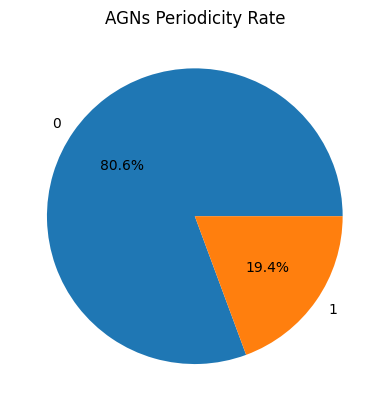

In [152]:
pie_x, pie_y = np.unique(dfn['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

### Machine Learining Models

In [153]:
#Apply a Random Forest classifier with the original dataset.

data2 = features_df1.copy()

# Split the data into features and target
X = data2.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data2['Periodicity']

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier2 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier2.fit(X2_train, y2_train)

# Make predictions on the test set
y2_pred = rf_classifier2.predict(X2_test)

# Evaluate the model
accuracy_score(y2_pred,y2_test)

0.9980867346938775

In [154]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier3 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier3.fit(X3_train, y3_train)

# Make predictions on the test set
y3_pred = rf_classifier3.predict(X3_test)

# Evaluate the model
accuracy_score(y3_pred,y3_test)

0.96

In [155]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data_2 = features_df1.copy()

# Split the data into features and target
X = data_2.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data_2['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X_res, y_res, test_size=0.3, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier4 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier4.fit(X4_train, y4_train)

# Make predictions on the test set
y4_pred = rf_classifier4.predict(X4_test)

# Evaluate the model
accuracy_score(y4_pred,y4_test)

0.9987179487179487

#### We use the metrics to evaluate the model

Metrics for the first model

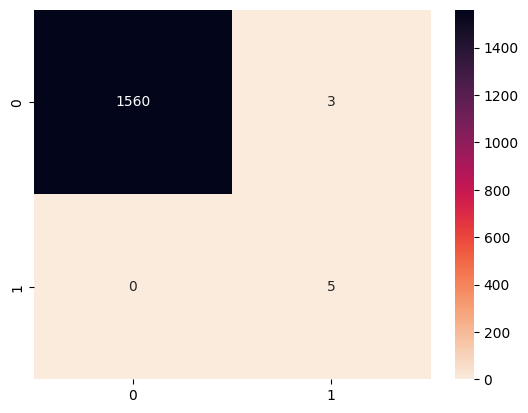

In [156]:
mc=confusion_matrix(y2_pred,y2_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [157]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='precision').mean()

1.0

In [158]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='recall').mean()

0.888888888888889

In [159]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='f1').mean()

0.8030303030303031

Metrics of second Random Forest Model

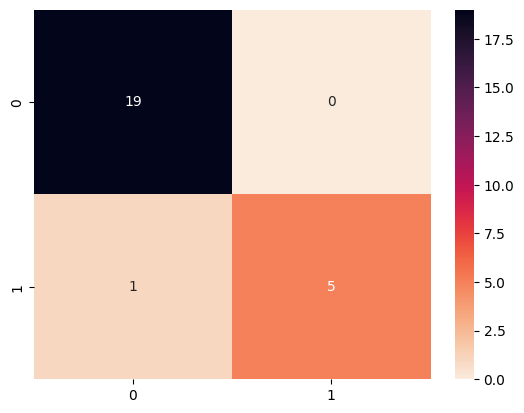

In [160]:
mc=confusion_matrix(y3_pred,y3_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [161]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='precision').mean()

1.0

In [162]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='recall').mean()

1.0

In [163]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='f1').mean()

1.0

Metrics of the last Model

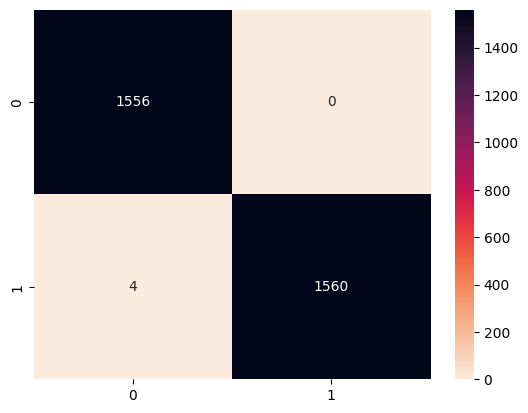

In [164]:
mc=confusion_matrix(y4_pred,y4_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [165]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='precision').mean()

0.9991771799763

In [166]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='recall').mean()

1.0

In [167]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='f1').mean()

0.9993137333963785

#### We'll try with one last model, whit an OverSampling in the undersampled dataset

In [168]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X5_train, X5_test, y5_train, y5_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier5 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier5.fit(X5_train, y5_train)

# Make predictions on the test set
y5_pred = rf_classifier5.predict(X5_test)

# Evaluate the model
accuracy_score(y5_pred,y5_test)

0.975

Calculate the metrics

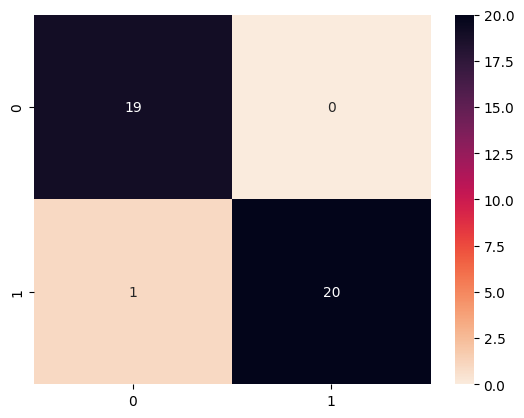

In [169]:
mc=confusion_matrix(y5_pred,y5_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [170]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='precision').mean()

1.0

In [171]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='recall').mean()

1.0

In [172]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='f1').mean()

0.9937106918238993

In [173]:
#Precision score
precision_score(y4_pred, y4_test)

1.0

In [174]:
#ROC AUC score
roc_auc_score(y4_pred,y4_test)

0.9987212276214834

In [175]:
#Recall score
recall_score(y4_test, y4_pred) 

1.0

In [176]:
#F1 score
f1_score(y4_test, y4_pred) 

0.998719590268886

In [177]:
print(classification_report(y4_test,y4_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      1.00      1.00      1560

    accuracy                           1.00      3120
   macro avg       1.00      1.00      1.00      3120
weighted avg       1.00      1.00      1.00      3120



In [180]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)

            # Store the features and the target variable
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_obs = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted = rf_classifier4.predict(features_df_obs)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs.to_csv('observations_AGNs.csv', index=False)

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is Periodic whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is Periodic whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
------------------------------------------------- agn_1116 is Periodic whit a probability of: 0.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is Periodic whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-24

In [181]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs
0,0.806667,0.000922,-0.400996,-0.672578,0208V-130815.csv
1,1.330000,0.001302,-0.703443,-1.500000,2149R-120815.csv
